In [1]:
import sys
sys.path.append('/kaggle/input/d2l-module')

### Kaggle 树叶分类

[https://www.kaggle.com/competitions/classify-leaves](https://www.kaggle.com/competitions/classify-leaves/)

In [2]:
import os
import math
import random
import collections
import torch
import torchvision
import pandas as pd
from torch import nn
from torch.utils import data
from torchvision import datasets,transforms
from datetime import datetime
from d2l import torch as d2l

# source_dir='../data/classify-leaves'
# data_dir='../data/classify-leaves'
source_dir='/kaggle/input/d2lclassifyleaves'
data_dir='/kaggle/working/'

整理数据集

In [3]:
def read_csv_labels(fname):
    """读取文件名序号映射到对应标签的字典"""
    with open(fname,'r') as f:
        lines=f.readlines()[1:] # 跳过文件头行
    tokens=[l.lstrip('images/').rstrip().split('.jpg,') for l in lines]
    return dict(((name,label) for name,label in tokens))

def reorg_train_valid(source_dir,data_dir,labels,valid_ratio):
    """分离训练集和测试集,并将验证集从原始的训练集中拆分出来"""
    n=collections.Counter(labels.values()).most_common()[-1][1] # 训练数据集中样本最少的类别中的样本数
    n_valid_per_label=max(1,math.floor(n*valid_ratio))          # 验证集中每个类别的样本数
    label_count={}
    for file in os.listdir(os.path.join(source_dir,'images')):
        fname=os.path.join(source_dir,'images',file)
        if int(file.split('.')[0])<len(labels):
            label=labels[file.split('.')[0]]
            d2l.copyfile(fname,os.path.join(data_dir,'train_valid_test','train_valid',label))
            if label not in label_count or label_count[label]<n_valid_per_label:
                d2l.copyfile(fname,os.path.join(data_dir,'train_valid_test','valid',label)) # 验证集
                label_count[label]=label_count.get(label,0)+1
            else:
                d2l.copyfile(fname,os.path.join(data_dir,'train_valid_test','train',label)) # 训练集
        else:
            d2l.copyfile(fname,os.path.join(data_dir,'train_valid_test','test','unknown'))  # 测试集
    return n_valid_per_label

labels=read_csv_labels(os.path.join(source_dir,'train.csv'))
n_valid_per_label=reorg_train_valid(source_dir,data_dir,labels,0.1)

print(f"train samples:\t{len(labels)-n_valid_per_label*len(set(labels.values()))}\n"
      f"valid samples:\t{n_valid_per_label*len(set(labels.values()))}\n"
      f"test samples:\t{len(os.listdir(os.path.join(data_dir,'train_valid_test','test','unknown')))}\n"
      f"categories:\t{len(set(labels.values()))}")

train samples:	17473
valid samples:	880
test samples:	8800
categories:	176


图像增广，读取数据集

In [4]:
transform_train=transforms.Compose([
    transforms.RandomRotation(degrees=(0,180)),
    transforms.RandomResizedCrop(224,scale=(0.25,1.0),ratio=(3.0/4.0,4.0/3.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.4,contrast=0.4,saturation=0.4),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

transform_test=transforms.Compose([
    transforms.RandomRotation(degrees=(0,180)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

train_ds,train_valid_ds=[datasets.ImageFolder(os.path.join(data_dir,'train_valid_test',folder),transform=transform_train) for folder in ['train','train_valid']]
valid_ds,test_ds=[datasets.ImageFolder(os.path.join(data_dir,'train_valid_test',folder),transform=transform_test) for folder in ['valid','test']]

batch_size=128
train_iter,train_valid_iter=[data.DataLoader(dataset,batch_size,shuffle=True,drop_last=True) for dataset in (train_ds,train_valid_ds)]
valid_iter=data.DataLoader(valid_ds,batch_size,shuffle=False,drop_last=True)
test_iter=data.DataLoader(test_ds,batch_size,shuffle=False,drop_last=False)

定义模型，采用预训练 ResNet-34 进行微调

In [5]:
def init_weights(m):
    if type(m)==nn.Linear:
        nn.init.xavier_uniform_(m.weight)

def get_net(devices,freeze=False):
    finetune_net=torchvision.models.resnet34(pretrained=True)
    finetune_net.fc=nn.Sequential(nn.Linear(512,256),nn.ReLU(),nn.Dropout(0.5),nn.Linear(256,176))
    finetune_net.fc.apply(init_weights)
    finetune_net=finetune_net.to(devices[0])
    if freeze:
        for name,param in finetune_net.named_parameters():
            if not name.startswith('fc'):
                param.requires_grad=False   # 冻结特征提取层的所有参数
    return finetune_net

训练函数

In [6]:
def train(net,train_iter,valid_iter,num_epochs,lr,wd,devices,param_group=True):
    loss=nn.CrossEntropyLoss(reduction='none')
    if param_group:     # 如果param_group=True,输出层中的模型参数将使用十倍的学习率
        params_1x=[param for name,param in net.named_parameters() if not name.startswith('fc')]
        trainer=torch.optim.SGD([{'params':params_1x},{'params':net.fc.parameters(),'lr':lr*10}],lr=lr,momentum=0.9,weight_decay=wd)
    else:
        trainer=torch.optim.SGD(net.parameters(),lr=lr,momentum=0.9,weight_decay=wd)
    scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(trainer,mode='min',factor=0.5,patience=3,verbose=True,min_lr=5e-8)
    timer,animator=d2l.Timer(),d2l.Animator(xlabel='epoch',xlim=[1,num_epochs],ylim=[0,1],legend=['train loss','train acc','valid acc'] if valid_iter is not None else ['train loss','train acc'])
    net=nn.DataParallel(net,device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        net.train()
        metric=d2l.Accumulator(3)
        for i,(features,labels) in enumerate(train_iter):
            timer.start()
            l,acc=d2l.train_batch_ch13(net,features,labels,loss,trainer,devices)
            metric.add(l,acc,labels.shape[0])
            timer.stop()
        animator.add(epoch+1,(metric[0]/metric[2],metric[1]/metric[2],None))
        if valid_iter is not None:
            valid_acc=d2l.evaluate_accuracy_gpu(net,valid_iter)
            animator.add(epoch+1,(None,None,valid_acc))
        scheduler.step(metric[0]/metric[2])
        if (epoch+1)%50==0 or epoch==num_epochs-1:
            torch.save(net.state_dict(),os.path.join(data_dir,'resnet34-leaves-'+str(epoch+1)+'epochs-'+datetime.now().isoformat()+'.pth'))
    print(f'train loss {metric[0]/metric[2]:.3f}, train acc {metric[1]/metric[2]:.3f}'+(f', valid acc {valid_acc:.3f}' if valid_iter is not None else '')+f'\n{metric[2]*num_epochs/timer.sum():.1f} examples/sec on {str(devices)}')

Private Score: 0.95295 Public Score: 0.94727

ReduceLROnPlateau ResNet-34

train loss 0.166, train acc 0.950, valid acc 0.940
384.5 examples/sec on [device(type='cuda', index=0), device(type='cuda', index=1)]


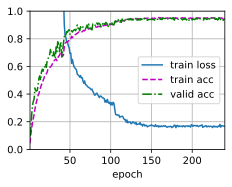

In [7]:
devices,num_epochs,lr,wd=d2l.try_all_gpus(),240,5e-5,5e-4
net=get_net(devices)
train(net,train_iter,valid_iter,num_epochs,lr,wd,devices)

In [8]:
# net=get_net(devices)
# train(net,train_valid_iter,None,num_epochs,lr,wd,devices)

preds=[]
net.eval()
for X,_ in test_iter:
    y_hat=net(X.to(devices[0]))
    preds.extend(y_hat.argmax(dim=1).type(torch.int32).cpu().numpy())
sorted_ids=['images/'+str(i)+'.jpg' for i in range(len(train_valid_ds),len(train_valid_ds)+len(test_ds))]
df=pd.DataFrame({'image':sorted_ids,'label':preds})
df['label']=df['label'].apply(lambda x:train_valid_ds.classes[x])
df.to_csv(os.path.join(data_dir,'submission.csv'),index=False)